<a href="https://colab.research.google.com/github/deepakri201/NLSTNatureSciData/blob/main/UsageNotes/NLSTSybilFMDemo/part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLST_Sybil_FM_demo_part4

In this notebook we use the featurs from FMCIB and MedSigLIP to train/val/test a classifier for identifiying the lung cancer stage.

Deepa Krishnaswamy

Brigham and Women's Hospital

August 2025

Notes:
- Colab Pro

# Parameterization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Copy the files that hold the features from Google Drive to here
# !cp "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/fmcib_features.csv" "/content"

In [ ]:
# !cp "/content/gdrive/MyDrive/Colab Notebooks/SR_NLST_Sybil/demo/medsiglip_features.csv" "/content"

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment Setup

In [ ]:
import os
import sys
import pandas as pd
import numpy as np

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
import matplotlib.pyplot as plt

# Load the data from the csvs

In [ ]:
!wget https://github.com/deepakri201/SR_for_NLST_Sybil/releases/download/v1.0.1/fmcib_features.csv
!wget https://github.com/deepakri201/SR_for_NLST_Sybil/releases/download/v1.0.1/medsiglip_features.csv

--2025-08-29 22:07:10--  https://github.com/deepakri201/SR_for_NLST_Sybil/releases/download/v1.0.1/fmcib_features.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/983681157/96134aac-e1fc-4dbc-8612-3cf29c568055?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-29T23%3A01%3A35Z&rscd=attachment%3B+filename%3Dfmcib_features.csv&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-29T22%3A01%3A14Z&ske=2025-08-29T23%3A01%3A35Z&sks=b&skv=2018-11-09&sig=5EQc%2BVo8BI2RCRE1zxZ8sWT%2F9uSpeI63M1SDXnDyxDQ%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjUwNTUzMSwibmJmIjoxNzU2NTA1MjMxLCJwYXRoIjoicmVsZWFzZWFzc2

In [ ]:
features_fmcib_df = pd.read_csv("/content/fmcib_features.csv")
features_medsiglip_df = pd.read_csv("/content/medsiglip_features.csv")

In [ ]:
features_fmcib_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'PatientID', 'SeriesInstanceUID',
       'SOPInstanceUID', 'image_path', 'coordX', 'coordY', 'coordZ', 'label',
       ...
       'pred_4086', 'pred_4087', 'pred_4088', 'pred_4089', 'pred_4090',
       'pred_4091', 'pred_4092', 'pred_4093', 'pred_4094', 'pred_4095'],
      dtype='object', length=4106)

In [ ]:
features_medsiglip_df.columns

Index(['Unnamed: 0', 'PatientID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'image_path', 'center_x_voxel', 'center_y_voxel', 'height_voxel',
       'width_voxel', 'min_x_voxel',
       ...
       'pred_1142', 'pred_1143', 'pred_1144', 'pred_1145', 'pred_1146',
       'pred_1147', 'pred_1148', 'pred_1149', 'pred_1150', 'pred_1151'],
      dtype='object', length=1166)

# Divide data into train/val/test

In [ ]:
# Divide the dataset by patients
# To keep somewhat balanced, for the train, val and test, we want a similar ratio of
# patients that have label=0 and label=1
patients = sorted(list(set(features_fmcib_df['PatientID'].values)))
num_patients = len(patients)
print('num_patients: ' + str(num_patients))

train_size = 0.6
val_size = 0.2
test_size = 0.2

# First create temp df with one row per patient

temp_df = features_fmcib_df.copy(deep=True)
temp_df = temp_df[['PatientID', 'label']]
temp_df = temp_df.drop_duplicates()

label_counts_df = temp_df['label'].value_counts()
label0_number = label_counts_df.values[0]
label1_number = label_counts_df.values[1]

PatientIDs_label0 = sorted(temp_df[temp_df['label']==0]['PatientID'].values)
PatientIDs_label1 = sorted(temp_df[temp_df['label']==1]['PatientID'].values)

print('label0_number: ' + str(label0_number))
print('label1_number: ' + str(label1_number))

# Now divide patients

num_train_patients_label0 = np.int32(np.floor(train_size * label0_number))
num_train_patients_label1 = np.int32(np.floor(train_size * label1_number))

num_val_patients_label0 = np.int32(np.floor(val_size * label0_number))
num_val_patients_label1 = np.int32(np.floor(val_size * label1_number))

num_test_patients_label0 = np.int32(np.floor(test_size * label0_number))
# num_test_patients_label1 = np.int32(np.floor(test_size * label1_number))
num_test_patients_label1 = num_patients - (num_train_patients_label0 + num_train_patients_label1 +
                                           num_val_patients_label0 + num_val_patients_label1 +
                                           num_test_patients_label0)

print('num_train_patients_label0: ' + str(num_train_patients_label0))
print('num_train_patients_label1: ' + str(num_train_patients_label1))

print('num_val_patients_label0: ' + str(num_val_patients_label0))
print('num_val_patients_label1: ' + str(num_val_patients_label1))

print('num_test_patients_label0: ' + str(num_test_patients_label0))
print('num_test_patients_label1: ' + str(num_test_patients_label1))

print(num_train_patients_label0 + num_train_patients_label1 +
      num_val_patients_label0 + num_val_patients_label1 +
      num_test_patients_label0 + num_test_patients_label1)


num_patients: 321
label0_number: 260
label1_number: 61
num_train_patients_label0: 156
num_train_patients_label1: 36
num_val_patients_label0: 52
num_val_patients_label1: 12
num_test_patients_label0: 52
num_test_patients_label1: 13
321


In [ ]:
# Now get the patient ids for train, val and test

train_ids = PatientIDs_label0[0:num_train_patients_label0] + \
            PatientIDs_label1[0:num_train_patients_label1]
val_ids = PatientIDs_label0[num_train_patients_label0:num_train_patients_label0 + num_val_patients_label0] + \
          PatientIDs_label1[num_train_patients_label1:num_train_patients_label1 + num_val_patients_label1]
test_ids = PatientIDs_label0[num_train_patients_label0 + num_val_patients_label0::] + \
           PatientIDs_label1[num_train_patients_label1 + num_val_patients_label1::]

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
print(len(train_ids) + len(val_ids) + len(test_ids))

# Create the dataframes for train, val and test

train_fmcib_df = features_fmcib_df[features_fmcib_df['PatientID'].isin(train_ids)]
val_fmcib_df = features_fmcib_df[features_fmcib_df['PatientID'].isin(val_ids)]
test_fmcib_df = features_fmcib_df[features_fmcib_df['PatientID'].isin(test_ids)]

train_medsiglip_df = features_medsiglip_df[features_medsiglip_df['PatientID'].isin(train_ids)]
val_medsiglip_df = features_medsiglip_df[features_medsiglip_df['PatientID'].isin(val_ids)]
test_medsiglip_df = features_medsiglip_df[features_medsiglip_df['PatientID'].isin(test_ids)]

# Now create the features and labels arrays

train_fmcib_X = train_fmcib_df[[f"pred_{idx}" for idx in range(4096)]]
val_fmcib_X = val_fmcib_df[[f"pred_{idx}" for idx in range(4096)]]
test_fmcib_X = test_fmcib_df[[f"pred_{idx}" for idx in range(4096)]]
train_fmcib_y = train_fmcib_df["label"]
val_fmcib_y = val_fmcib_df["label"]
test_fmcib_y = test_fmcib_df["label"]

train_medsiglip_X = train_medsiglip_df[[f"pred_{idx}" for idx in range(1151)]]
val_medsiglip_X = val_medsiglip_df[[f"pred_{idx}" for idx in range(1151)]]
test_medsiglip_X = test_medsiglip_df[[f"pred_{idx}" for idx in range(1151)]]
train_medsiglip_y = train_medsiglip_df["label"]
val_medsiglip_y = val_medsiglip_df["label"]
test_medsiglip_y = test_medsiglip_df["label"]

print('train_fmcib_X: ' + str(train_fmcib_X.shape))
print('val_fmcib_X: ' + str(val_fmcib_X.shape))
print('test_fmcib_X: ' + str(test_fmcib_X.shape))
print('train_fmcib_y: ' + str(len(train_fmcib_y)))
print('val_fmcib_y: ' + str(len(val_fmcib_y)))
print('test_fmcib_y: ' + str(len(test_fmcib_y)))
print(np.unique(train_fmcib_y))
print(np.unique(val_fmcib_y))
print(np.unique(test_fmcib_y))

print('train_medsiglip_X: ' + str(train_medsiglip_X.shape))
print('val_medsiglip_X: ' + str(val_medsiglip_X.shape))
print('test_medsiglip_X: ' + str(test_medsiglip_X.shape))
print('train_medsiglip_y: ' + str(len(train_medsiglip_y)))
print('val_medsiglip_y: ' + str(len(val_medsiglip_y)))
print('test_medsiglip_y: ' + str(len(test_medsiglip_y)))
print(np.unique(train_medsiglip_y))
print(np.unique(val_medsiglip_y))
print(np.unique(test_medsiglip_y))

# # modify 5/6 to 0/1
# train_y = [f-5 for f in train_y]
# val_y = [f-5 for f in val_y]
# test_y = [f-5 for f in test_y]


192
64
65
321
train_fmcib_X: (305, 4096)
val_fmcib_X: (102, 4096)
test_fmcib_X: (118, 4096)
train_fmcib_y: 305
val_fmcib_y: 102
test_fmcib_y: 118
[0 1]
[0 1]
[0 1]
train_medsiglip_X: (305, 1151)
val_medsiglip_X: (102, 1151)
test_medsiglip_X: (118, 1151)
train_medsiglip_y: 305
val_medsiglip_y: 102
test_medsiglip_y: 118
[0 1]
[0 1]
[0 1]


# Train/val/test the classifiers for FMCIB


In [ ]:
linear_model_fmcib = LogisticRegression(C=0.001, max_iter=1000)

# Training loop with simple hyperparameter search using validation set
C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_val_score = 0
best_model = None

for C in C_range:
  linear_model_fmcib = LogisticRegression(C=C, max_iter=1000)
  linear_model_fmcib.fit(train_fmcib_X, train_fmcib_y)
  val_pred = linear_model_fmcib.predict_proba(val_fmcib_X)[:, 1]
  val_score = roc_auc_score(val_fmcib_y, val_pred)

  print(f"C = {C}: Validation accuracy = {val_score}")

  # Keep track of the best model
  if val_score > best_val_score:
      best_val_score = val_score
      best_model = linear_model_fmcib

print(f"Best Validation accuracy: {best_val_score}")

C = 0.0001: Validation accuracy = 0.6653824986241057
C = 0.001: Validation accuracy = 0.740231150247661
C = 0.01: Validation accuracy = 0.7363786461199779
C = 0.1: Validation accuracy = 0.7187671986791414
C = 1: Validation accuracy = 0.709411117226197
C = 10: Validation accuracy = 0.7066593285635663
C = 100: Validation accuracy = 0.7198679141441938
Best Validation accuracy: 0.740231150247661


In [ ]:
# Results on the test dataset

test_pred = best_model.predict_proba(test_fmcib_X)[:, 1]
test_score = roc_auc_score(test_fmcib_y, test_pred)
print(f"Score on the testing data: {test_score}")

Score on the testing data: 0.6066053511705686


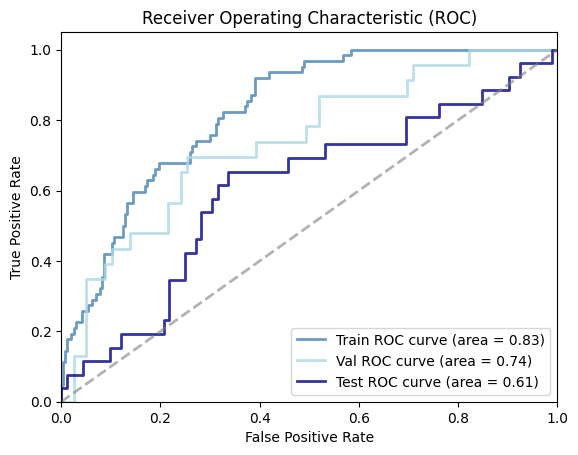

In [ ]:
# Plot ROC-Curves for train-val-test
# Here we plot ROC-Curves to compare performance between train, val and test splits

plt.figure()
lw = 2


split_map = {
    "Train": [train_fmcib_X, train_fmcib_y, "steelblue"],
    "Val": [val_fmcib_X, val_fmcib_y, "lightblue"],
    "Test": [test_fmcib_X, test_fmcib_y, "darkblue"]
}

for split in ["Train", "Val", "Test"]:
  feats, label, color = split_map[split]
  fpr, tpr, thresholds = roc_curve(label, best_model.predict_proba(feats)[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color=color, lw=lw, label=f'{split} ROC curve (area = %0.2f)' % roc_auc, alpha=0.8)

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Train/val/test the classifiers for MedSigLIP


In [ ]:
linear_model_medsiglip = LogisticRegression(C=0.001, max_iter=1000)

# Training loop with simple hyperparameter search using validation set
C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_val_score = 0
best_model = None

for C in C_range:
  linear_model_medsiglip = LogisticRegression(C=C, max_iter=1000)
  linear_model_medsiglip.fit(train_medsiglip_X, train_medsiglip_y)
  val_pred = linear_model_medsiglip.predict_proba(val_medsiglip_X)[:, 1]
  val_score = roc_auc_score(val_medsiglip_y, val_pred)

  print(f"C = {C}: Validation accuracy = {val_score}")

  # Keep track of the best model
  if val_score > best_val_score:
      best_val_score = val_score
      best_model = linear_model_medsiglip

print(f"Best Validation accuracy: {best_val_score}")

C = 0.0001: Validation accuracy = 0.7705008255365987
C = 0.001: Validation accuracy = 0.7710511832691249
C = 0.01: Validation accuracy = 0.7710511832691249
C = 0.1: Validation accuracy = 0.7666483214089158
C = 1: Validation accuracy = 0.7215189873417721
C = 10: Validation accuracy = 0.5806274078150798
C = 100: Validation accuracy = 0.47605943863511285
Best Validation accuracy: 0.7710511832691249


In [ ]:
# Results on the test dataset

test_pred = best_model.predict_proba(test_medsiglip_X)[:, 1]
test_score = roc_auc_score(test_medsiglip_y, test_pred)
print(f"Score on the testing data: {test_score}")

Score on the testing data: 0.6797658862876255


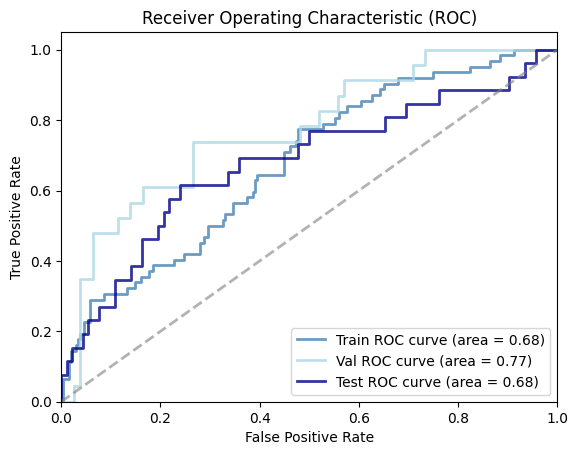

In [ ]:
# Plot ROC-Curves for train-val-test
# Here we plot ROC-Curves to compare performance between train, val and test splits

plt.figure()
lw = 2


split_map = {
    "Train": [train_medsiglip_X, train_medsiglip_y, "steelblue"],
    "Val": [val_medsiglip_X, val_medsiglip_y, "lightblue"],
    "Test": [test_medsiglip_X, test_medsiglip_y, "darkblue"]
}

for split in ["Train", "Val", "Test"]:
  feats, label, color = split_map[split]
  fpr, tpr, thresholds = roc_curve(label, best_model.predict_proba(feats)[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color=color, lw=lw, label=f'{split} ROC curve (area = %0.2f)' % roc_auc, alpha=0.8)

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()